# Clean AVIRIS CH4 Plume Estimates at VISTA Points

## ER 131 Project | Group 4
**Author: ** ['Marshall Worsham'] <br>
**Date: ** 12-14-2020

## Libraries

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import re
import time
from matplotlib import pyplot as plt

## Set working directories

In [3]:
datadir = os.sep.join(['/Volumes', 'Brain', 'GIS', 'ER131', 'Project', 'Data'])
outdir = os.sep.join(['/Volumes', 'Brain', 'GIS', 'ER131', 'Project', 'Output'])

#### Steps 1 and 2. 
We did the buffering and mean CH$_4$ calculations in QGIS (see `01_Extract_Aviris_CH4.ipynb` in our Git repository for a valiant attempt in Python).

To complete the remaining cleaning steps, we first imported the geojsons exported from QGIS. These contain polygon buffers of 100m radius around the original VISTA points and polygons. Each object stores an estimate of the mean CH$_4$ enhancement in a 1m-high column above the buffer (ppm m), count of pixels that went into calculating the mean, and the standard deviation. In QGIS, we had to process point and polygon geometries separately; we imported the two geojsons here and made a final merge at the end of this module.


In [4]:
aviris_points_path = os.sep.join([outdir, 'CH4_Emitters', 'CH4_Emitters_Pts_Buff100.geojson'])
aviris_poly_path = os.sep.join([outdir, 'CH4_Emitters', 'CH4_Emitters_Poly_Buff100.geojson'])

In [9]:
aviris_points = gpd.read_file(aviris_points_path, low_memory = False)

KeyboardInterrupt: 

In [5]:
aviris_poly = gpd.read_file(aviris_poly_path, low_memory = False)

In [6]:
# drop a few extraneous columns from aviris_poly
aviris_poly = aviris_poly.drop(columns=['_count', '_mean', '_median', '_stdev', '_min', '_max', 'OUT_count', 'OUT_mean', 'OUT_median', 'OUT_stdev'])

Here's a summary of the points geodataframe.

In [7]:
print(aviris_points.shape)
aviris_points.head()

NameError: name 'aviris_points' is not defined

Here's a summary of the polygons geodataframe.

In [8]:
print(aviris_poly.shape)
aviris_poly.head()

(5903, 1798)


,Latitude,Longitude,Vista_IPCC,Vista_Name,Vista_SType,Vista_ID,Vista_Date,State,City,Source,...,CH4_278mean,CH4_211mean,CH4_288count,CH4_288sum,CH4_288mean,CH4_297count,CH4_297sum,CH4_297mean,CH4_556mean,geometry
0,37.72799,-120.89865,4B Biological Treatment of Solid Waste,"3D Ag, LLC",Composting Sites,CMP000001,2019-08-20,CA,Oakdale,CalRecycle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-79102.941 -31573.212, -79085...."
1,33.70999,-117.32864,4B Biological Treatment of Solid Waste,"A. Lua Recycling, Inc.",Composting Sites,CMP000002,2019-08-20,CA,Lake Elsinore,CalRecycle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((247654.698 -474731.555, 247672..."
2,38.01667,-122.13333,4B Biological Treatment of Solid Waste,Acme Composting Compost Facility,Composting Sites,CMP000003,2019-08-20,CA,Martinez,CalRecycle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-187037.557 2247.982, -187020...."
3,34.03281,-118.35424,4B Biological Treatment of Solid Waste,Adams Garden Supply,Composting Sites,CMP000004,2019-08-20,CA,Los Angeles (City),CalRecycle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((151961.759 -441099.032, 151979..."
4,34.44517,-117.29007,4B Biological Treatment of Solid Waste,Advance Disposal Center for the Environm,Composting Sites,CMP000005,2019-08-20,CA,Hesperia,CalRecycle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((248898.801 -393109.002, 248916..."


#### Step 3. Set mean values below threshold to NaN
We set mean CH$_4$ values that fell below a mixing-ratio threshold of 100 ppm m (i.e., pixels where [CH$_4$] was less than 100 ppm m above background) to NaN to exclude non-emitting facilities.  First, we defined a function that separates the dataframes by observation type (mean observation, pixel count, and standard deviation) so they're a little more manageable.

In [5]:
def split_dfs(df, field):
     '''
     Takes in a dataframe and a specified observation type and returns a dataframe sliced by that observation type,
     while preserving original index order.
     '''
     field_subset = df[[col for col in df.columns if field in col]]

     # isolate the column index number
     col_indices = []
     cols = list(field_subset.columns)
     col_strs = [col[-7:] for col in cols]

     #find the index number of the flightpath corresponding to the aviris column
     for col in col_strs:
          inds = [int(s) for s in re.findall(r'[0-9]+', col)][0]
          col_indices.append(inds-1)

     # generate the column names
     flightids = [fp[3:18] for fp in flightpaths]
     flightids = [flightids[i] for i in col_indices]
     colnames = ['AVIRIS_CH4_' + field + '_' + fid for fid in flightids]

     # rename columns
     field_subset.columns = colnames
     field_subset.columns = field_subset.columns.sort_values()

     return field_subset

We ran this function on both the point and polygon dataframes.

In [567]:
aviris_points_mean = split_dfs(aviris_points, 'mean')
aviris_points_count = split_dfs(aviris_points, 'count')
aviris_points_std = split_dfs(aviris_points, 'std')

In [ ]:
aviris_poly_mean = split_dfs(aviris_poly, 'mean')
aviris_poly_count = split_dfs(aviris_poly, 'count')
aviris_poly_std = split_dfs(aviris_poly, 'std')

In [ ]:
aviris_points_mean[aviris_points_mean < 100] = np.nan
aviris_poly_mean[aviris_poly_mean < 100] = np.nan

#### Step 4. Where there are multiple observations, take the median value

In some cases, multiple flights were made, and multiple CH$_4$ observations recorded, over the same facility. How many mean observations are there for each facility?

In [ ]:
print(aviris_points_mean.count(axis = 1).unique())
print(aviris_poly_mean.count(axis = 1).unique())

Where there was more than one observation, we took the median value from that facility's distribution.

In [338]:
aviris_points_ch4 = aviris_points_mean.median(axis = 1, skipna = True)
aviris_poly_ch4 = aviris_poly_mean.median(axis = 1, skipna = True)

<AxesSubplot:>

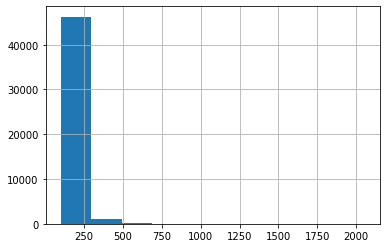

In [344]:
aviris_points_ch4.hist(bins = 12)
aviris_poly_ch4.hist(bins = 12)

When we execute the final data merge before running our regression models, we'll want to select some of the other features' observations according to the year and month for which we have AVIRIS-derived CH$_4$ estimates. To do that, we need the year and month corresponding to each observation in the response. We make that happen here by finding the column of the median $CH_4$ mean observation and matching it to the original AVIRIS raster's name, which contains the flight date.

In [339]:
def get_median_index(d):
    d = d.transpose()
    ranks = d.rank(pct=True)
    close_to_median = abs(ranks - 0.5)
    med_idx = close_to_median.idxmin()
    return med_idx

In [340]:
# get indices of medians for points
aviris_points_ch4_idx = pd.DataFrame({'aviris_col':get_median_index(aviris_points_mean)})
aviris_points_ch4_idx['aviris_col'] = [str(i) for i in aviris_points_ch4_idx['aviris_col']]

# get indices of medians for polygons
aviris_poly_ch4_idx = pd.DataFrame({'aviris_col':get_median_index(aviris_poly_mean)})
aviris_poly_ch4_idx['aviris_col'] = [str(i) for i in aviris_poly_ch4_idx['aviris_col']]

In [414]:
# load the list of filenames from the AVIRIS directory
flightpaths = pd.read_csv('Data/AVIRIS_Flightpath_Filenames.csv')
flightdates = [fid[16:24] for fid in list(aviris_points_mean.columns)]
datekey = pd.DataFrame({'aviris_col':aviris_points_mean.columns, 'date':flightdates})

In [ ]:
aviris_points_ch4_dates = aviris_points_ch4_idx.merge(datekey, how = 'left', on = 'aviris_col')
aviris_poly_ch4_dates = aviris_poly_ch4_idx.merge(datekey, how = 'left', on = 'aviris_col')

In [579]:
aviris_points_ch4_pxcounts = aviris_points_count.mean(axis = 1, skipna = True)
aviris_poly_ch4_pxcounts = aviris_points_count.mean(axis = 1, skipna = True)

Next, we create a final response dataframe by specifying the columns we want to preserve from the steps above and then merging the points and polygons dataframes.

In [387]:
aviris_points_base = aviris.loc[:,['Latitude', 'Longitude', 'Vista_IPCC', 'Vista_Name', 'Vista_SType',
       'Vista_ID', 'Vista_Date', 'State', 'City', 'Source', 'geometry']]
aviris_points_base['AVIRIS_CH4_median_ppmm'] = aviris_points_ch4
aviris_points_base['AVIRIS_CH4_median_date'] = aviris_points_ch4_dates['date']
aviris_points_base['AVIRIS_CH4_pxcount'] = aviris_points_ch4_pxcounts

In [777]:
aviris_base[aviris_base['AVIRIS_CH4_median_ppmm'].notna()].head(5)

,Latitude,Longitude,Vista_IPCC,Vista_Name,Vista_SType,Vista_ID,Vista_Date,State,City,Source,geometry,AVIRIS_CH4_median_ppmm,AVIRIS_CH4_median_date,AVIRIS_CH4_pxcount
17,37.861643,-120.939994,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001852,2019-11-10,CA,FARMINGTON,RAFIQ,"MULTIPOLYGON (((-82488.739 -16790.579, -82489....",152.003863,20160911,835.750000
29,34.901523,-117.151102,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001876,2019-11-10,CA,HINKLEY,RAFIQ,"MULTIPOLYGON (((260247.391 -342212.585, 260246...",111.881426,20160912,1670.000000
54,35.903687,-119.317296,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001759,2019-11-10,CA,EARLIMART,RAFIQ,"MULTIPOLYGON (((61647.033 -234595.348, 61646.1...",244.122330,20160912,3346.000000
57,35.994762,-119.497973,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001767,2019-11-10,CA,CORCORAN,RAFIQ,"MULTIPOLYGON (((45304.763 -224578.476, 45303.9...",112.788443,20160912,1114.666667
61,36.181868,-119.560789,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001776,2019-11-10,CA,HANFORD,RAFIQ,"MULTIPOLYGON (((39551.942 -203816.734, 39551.1...",105.410700,20160912,1216.272727


In [613]:
aviris_poly_base = aviris_poly.loc[:,['Latitude', 'Longitude', 'Vista_IPCC', 'Vista_Name', 'Vista_SType',
       'Vista_ID', 'Vista_Date', 'State', 'City', 'Source', 'geometry']]
aviris_poly_base['AVIRIS_CH4_median_ppmm'] = aviris_poly_ch4
aviris_poly_base['AVIRIS_CH4_median_date'] = aviris_poly_ch4_dates['date']
aviris_poly_base['AVIRIS_CH4_pxcount'] = aviris_poly_ch4_pxcounts

In [595]:
aviris_poly_base[aviris_poly_base['AVIRIS_CH4_median_ppmm'].notna()].head(5)

,Latitude,Longitude,Vista_IPCC,Vista_Name,Vista_SType,Vista_ID,Vista_Date,State,City,Source,geometry,AVIRIS_CH4_median_ppmm,AVIRIS_CH4_median_date,AVIRIS_CH4_pxcount
2,NaN,NaN,4B Biological Treatment of Solid Waste,Acme Composting Compost Facility,Composting Sites,CMP000003,2019-08-20,CA,Martinez,CalRecycle,"MULTIPOLYGON (((-187037.557 2247.982, -187020....",111.085646,20160910,4206.333333
23,NaN,NaN,4B Biological Treatment of Solid Waste,"Atlas Tree Service, Inc.",Composting Sites,CMP000024,2019-08-20,CA,Concord,CalRecycle,"MULTIPOLYGON (((-177591.083 2522.210, -177573....",316.934235,20160910,4208.000000


In [601]:
assert aviris_points_base.columns.all() == aviris_poly_base.columns.all()

In [765]:
aviris_ch4_all = pd.concat([aviris_base, aviris_poly_base], axis = 0, ignore_index = True)

In [946]:
aviris_ch4_all[aviris_ch4_all['AVIRIS_CH4_median_date'].notna()].head(5)

,Latitude,Longitude,Vista_IPCC,Vista_Name,Vista_SType,Vista_ID,Vista_Date,State,City,Source,geometry,AVIRIS_CH4_median_ppmm,AVIRIS_CH4_median_date,AVIRIS_CH4_pxcount,CH4_Mass_kg
17,37.861643,-120.939994,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001852,2019-11-10,CA,FARMINGTON,RAFIQ,"MULTIPOLYGON (((-82488.739 -16790.579, -82489....",152.003863,20160911,835.750000,0.000107
29,34.901523,-117.151102,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001876,2019-11-10,CA,HINKLEY,RAFIQ,"MULTIPOLYGON (((260247.391 -342212.585, 260246...",111.881426,20160912,1670.000000,0.000079
54,35.903687,-119.317296,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001759,2019-11-10,CA,EARLIMART,RAFIQ,"MULTIPOLYGON (((61647.033 -234595.348, 61646.1...",244.122330,20160912,3346.000000,0.000172
57,35.994762,-119.497973,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001767,2019-11-10,CA,CORCORAN,RAFIQ,"MULTIPOLYGON (((45304.763 -224578.476, 45303.9...",112.788443,20160912,1114.666667,0.000080
61,36.181868,-119.560789,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001776,2019-11-10,CA,HANFORD,RAFIQ,"MULTIPOLYGON (((39551.942 -203816.734, 39551.1...",105.410700,20160912,1216.272727,0.000074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234449,NaN,NaN,4D1 & 4D2 Domestic Wastewater Treatment and Di...,Delta Diablo S.D.,Wastewater Treatment Plant,WWT000027,2019-08-20,CA,Antioch,CARB,"MULTIPOLYGON (((-162518.517 1629.418, -162411....",154.098369,20160910,81837.000000,0.000109
234555,NaN,NaN,4D1 & 4D2 Domestic Wastewater Treatment and Di...,ORANGE COUNTY S.D. #2,Wastewater Treatment Plant,WWT000087,2019-08-20,CA,Huntington Beach,CARB,"MULTIPOLYGON (((189558.884 -483604.172, 189625...",133.962115,20170902,76859.333333,0.000095
234558,NaN,NaN,4D1 & 4D2 Domestic Wastewater Treatment and Di...,LACSD Valencia WRP,Wastewater Treatment Plant,WWT000060,2019-08-20,CA,Valencia,CARB,"MULTIPOLYGON (((129586.403 -397723.721, 129580...",107.186755,20171013,18890.911765,0.000076
234559,NaN,NaN,4D1 & 4D2 Domestic Wastewater Treatment and Di...,LACSD Joint WPCP,Wastewater Treatment Plant,WWT000059,2019-08-20,CA,Carson,CARB,"MULTIPOLYGON (((158451.241 -466745.518, 158445...",252.101421,20170902,107844.857143,0.000178


In [767]:
aviris_ch4_all[aviris_ch4_all['AVIRIS_CH4_median_ppmm'].notna()].head(5)

,Latitude,Longitude,Vista_IPCC,Vista_Name,Vista_SType,Vista_ID,Vista_Date,State,City,Source,geometry,AVIRIS_CH4_median_ppmm,AVIRIS_CH4_median_date,AVIRIS_CH4_pxcount
17,37.861643,-120.939994,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001852,2019-11-10,CA,FARMINGTON,RAFIQ,"MULTIPOLYGON (((-82488.739 -16790.579, -82489....",152.003863,20160911,835.750000
29,34.901523,-117.151102,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001876,2019-11-10,CA,HINKLEY,RAFIQ,"MULTIPOLYGON (((260247.391 -342212.585, 260246...",111.881426,20160912,1670.000000
54,35.903687,-119.317296,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001759,2019-11-10,CA,EARLIMART,RAFIQ,"MULTIPOLYGON (((61647.033 -234595.348, 61646.1...",244.122330,20160912,3346.000000
57,35.994762,-119.497973,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001767,2019-11-10,CA,CORCORAN,RAFIQ,"MULTIPOLYGON (((45304.763 -224578.476, 45303.9...",112.788443,20160912,1114.666667
61,36.181868,-119.560789,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001776,2019-11-10,CA,HANFORD,RAFIQ,"MULTIPOLYGON (((39551.942 -203816.734, 39551.1...",105.410700,20160912,1216.272727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234449,NaN,NaN,4D1 & 4D2 Domestic Wastewater Treatment and Di...,Delta Diablo S.D.,Wastewater Treatment Plant,WWT000027,2019-08-20,CA,Antioch,CARB,"MULTIPOLYGON (((-162518.517 1629.418, -162411....",154.098369,20160910,81837.000000
234555,NaN,NaN,4D1 & 4D2 Domestic Wastewater Treatment and Di...,ORANGE COUNTY S.D. #2,Wastewater Treatment Plant,WWT000087,2019-08-20,CA,Huntington Beach,CARB,"MULTIPOLYGON (((189558.884 -483604.172, 189625...",133.962115,20170902,76859.333333
234558,NaN,NaN,4D1 & 4D2 Domestic Wastewater Treatment and Di...,LACSD Valencia WRP,Wastewater Treatment Plant,WWT000060,2019-08-20,CA,Valencia,CARB,"MULTIPOLYGON (((129586.403 -397723.721, 129580...",107.186755,20171013,18890.911765
234559,NaN,NaN,4D1 & 4D2 Domestic Wastewater Treatment and Di...,LACSD Joint WPCP,Wastewater Treatment Plant,WWT000059,2019-08-20,CA,Carson,CARB,"MULTIPOLYGON (((158451.241 -466745.518, 158445...",252.101421,20170902,107844.857143


#### Step 5. 
Finally, we calculate an estimate of emitted CH$_4$ mass in the column above each point using the formula
$$IME = k \sum_{i=0}^{p}(a_i)(S_i)$$ 
where:
* $a_i$ = zonal mean CH$_4$ enhancement (ppm m),
* $S_i$ = area used to compute IME ($n$ pixels x 9m$^2$ pixel area [m$^2$])
* $k$ = a unit conversion to CH$_4$ mass (kg)

In [ ]:
# calculate area
count = aviris_ch4_all['AVIRIS_CH4_pxcount']
area = count * 9 # m2

# calculate k
m = 16.04 # g CH4/mol
a = 22.71108 # L/mol of gas, assuming STP
vL = 1000 #L/m3
gkg = 1e-3
k = m * 1/a * 1/vc * gkg

# define IEM as median CH4 enhancement (ppm m)
iem = aviris_ch4_all['AVIRIS_CH4_median_ppmm']

# caculate mass
mass = iem * area * k

We added the mass estimate as a new column to the `aviris_ch4_all` geodataframe. This will later become our response variable. We exported the final dataframe as a geojson for subsequent merging with features.

In [943]:
aviris_ch4_all['CH4_Mass_kg'] = mass

In [945]:
# aviris_ch4_all.to_file(os.sep.join([outdir, 'AVIRIS_CH4.geojson']), driver = 'GeoJSON')